In [19]:
import random

import numpy as np

import plotly.express as px

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

from instance_mongodb import instance_mongodb_sei

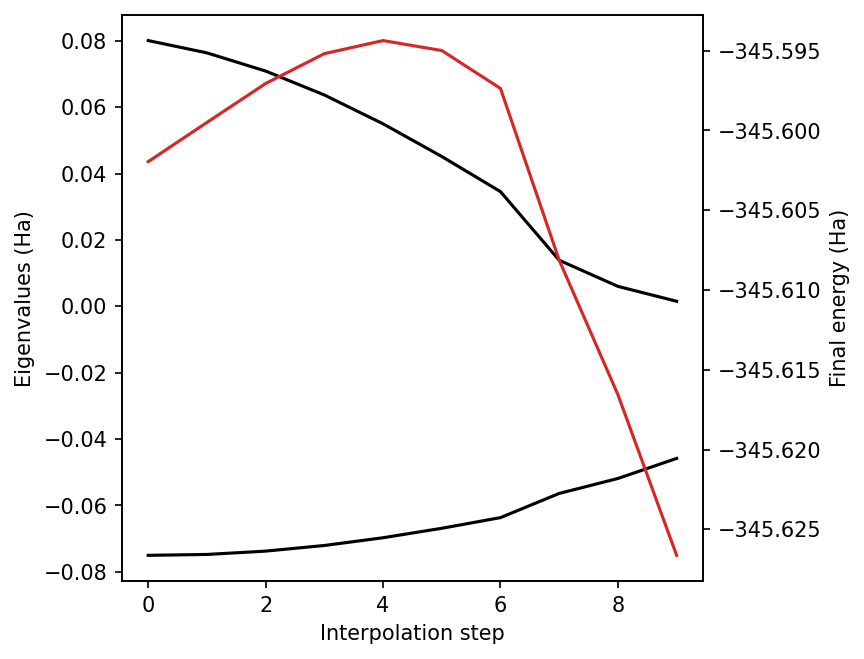

In [22]:
def get_quantities(cursor):
    """Get quantities that are needed for plotting."""
    for document in cursor:

        alpha_eigenvalues = document["calcs_reversed"][0]["alpha_eigenvalues"]
        final_energy = document["output"]["final_energy"]

        alpha_eigenvalues = np.sort(alpha_eigenvalues)
        positive_alpha_eigenvalues = alpha_eigenvalues[alpha_eigenvalues > 0]
        negative_alpha_eigenvalues = alpha_eigenvalues[alpha_eigenvalues < 0]

        homo = negative_alpha_eigenvalues[-1] 
        lumo = positive_alpha_eigenvalues[0]

        yield final_energy, homo, lumo

db = instance_mongodb_sei(project="mlts")

collections_data = db.minimal_basis

# Create a new collection to store the data in
collections_data_new = db.minimal_basis_interpolated_sn2
groupname = "sn2_interpolated_from_transition_states"

# Find all unique reaction labels
reaction_labels = collections_data.distinct("tags.label")
# Randomlise the reaction labels
random.shuffle(reaction_labels)

df = pd.DataFrame()

for reaction_label in reaction_labels:

    cursor = (
        collections_data.find(
            {
                "tags.label": reaction_label,
                "tags.group": groupname,
            }
        )
        .sort("tags.scaling", 1)
    )

    plot_data = list(get_quantities(cursor))
    plot_data = np.array(plot_data)
    final_energy, homo, lumo = plot_data.T

    # Make a plot with twin y-axis. One plotting
    # the homo and lumo and the other one plotting
    # the final energy using plotly express
    fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    ax2 = ax1.twinx()
    ax1.plot(homo, color='k')
    ax1.plot(lumo, color='k')
    ax2.plot(final_energy, color='tab:red')
    ax1.set_xlabel("Interpolation step")
    ax1.set_ylabel("Eigenvalues (Ha)")
    ax2.set_ylabel("Final energy (Ha)")
    break
    